In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
import scipy.stats as scs
from tqdm import tqdm_notebook

from sklearn.metrics import mean_absolute_error

#  daily-min-temperature

Iniciamos abriendo el archivo de datos mediante la libreria de datos pandas

In [2]:
df= pd.read_csv('daily-min-temperatures.csv',sep=';',index_col=0)

visualizamos algunos datos cargados para ver el tipo de datos que tenemos

In [3]:
df.head()

,Date,Temp
0,1981-01-01,"20,7"
1,1981-01-02,"17,9"
2,1981-01-03,"18,8"
3,1981-01-04,"14,6"
4,1981-01-05,"15,8"


In [4]:
# Seún la información de los datos, se encuentran en el tipo de dato objeto y no posee espacios vacíos
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    3650 non-null   object
 1   Temp    3650 non-null   object
dtypes: object(2)
memory usage: 85.5+ KB


Claramente nuestros datos se componen de una serie de datos ordenados de manera cronológica, lo que significa tratamos con una serie de tiempo.
Para tal caso, es conveniente convertir en datos temporales a la columna de fecha (Date) y a su vez, convertir de objeto a float la columna de 
Temperatura (Temp), esto último para poder manipular de manera correcta las cantidades y sacar estadísticas.

In [5]:
# Conversión de los datos
df.Date, df.Temp = pd.to_datetime(df.Date), df.Temp.str.replace(',','.').astype('float')
df

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


In [6]:
# La primera columna de datos, correspondiente al índice numérico por defecto, no es relevante por 
# lo tanto decidimos tomar la columna de fecha como la correspondiente al índice
df.set_index('Date', inplace=True)

In [7]:
# De nuevo, observando los datos pero en el nuevo tipo float vemos que no aparecen de nuevo datos nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3650 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Temp    3650 non-null   float64
dtypes: float64(1)
memory usage: 57.0 KB


Teniendo definida nuestra serie de tiempo, debemos establecer la periodicidad de esta, para este caso los datos se visualizan de forma mejor
cuando se trabaja con una periodicidad semanal ('w') lo que es factible debido a la gran cantidad de datos.
Por otra parte, no dejamos espacios inconclusos o NaN que no aporten a las estadísticas, para tal caso utilizamos el método fillna hacia adelante ffill.

In [8]:
df = df.asfreq('W')
df.fillna(method='ffill', inplace=True)
df

,Temp
Date,
1981-01-04,14.6
1981-01-11,16.2
1981-01-18,24.8
1981-01-25,16.5
1981-02-01,15.3
...,...
1990-12-02,13.2
1990-12-09,14.1
1990-12-16,13.6


In [9]:
# Un estadístico más, es el promedio de la temperatura en el último año
def media_movil(s, n):
    avg = np.average(s[-n:]).round(2)
    print('promedio de los últimos', n, 'días:', avg)

media_movil(df,365)

promedio de los últimos 365 días: 11.06


A continuación, presentamos una serie de gráficos, en los cuales podemos ver la forma general de la serie de tiempo original.También, se visualizan las fluctuaciones de la serie, la cual muestra una tendencia final de crecimiento.
Finalmente, se muestran las gráficas de variaciones estacionales y variaciones irregulares.

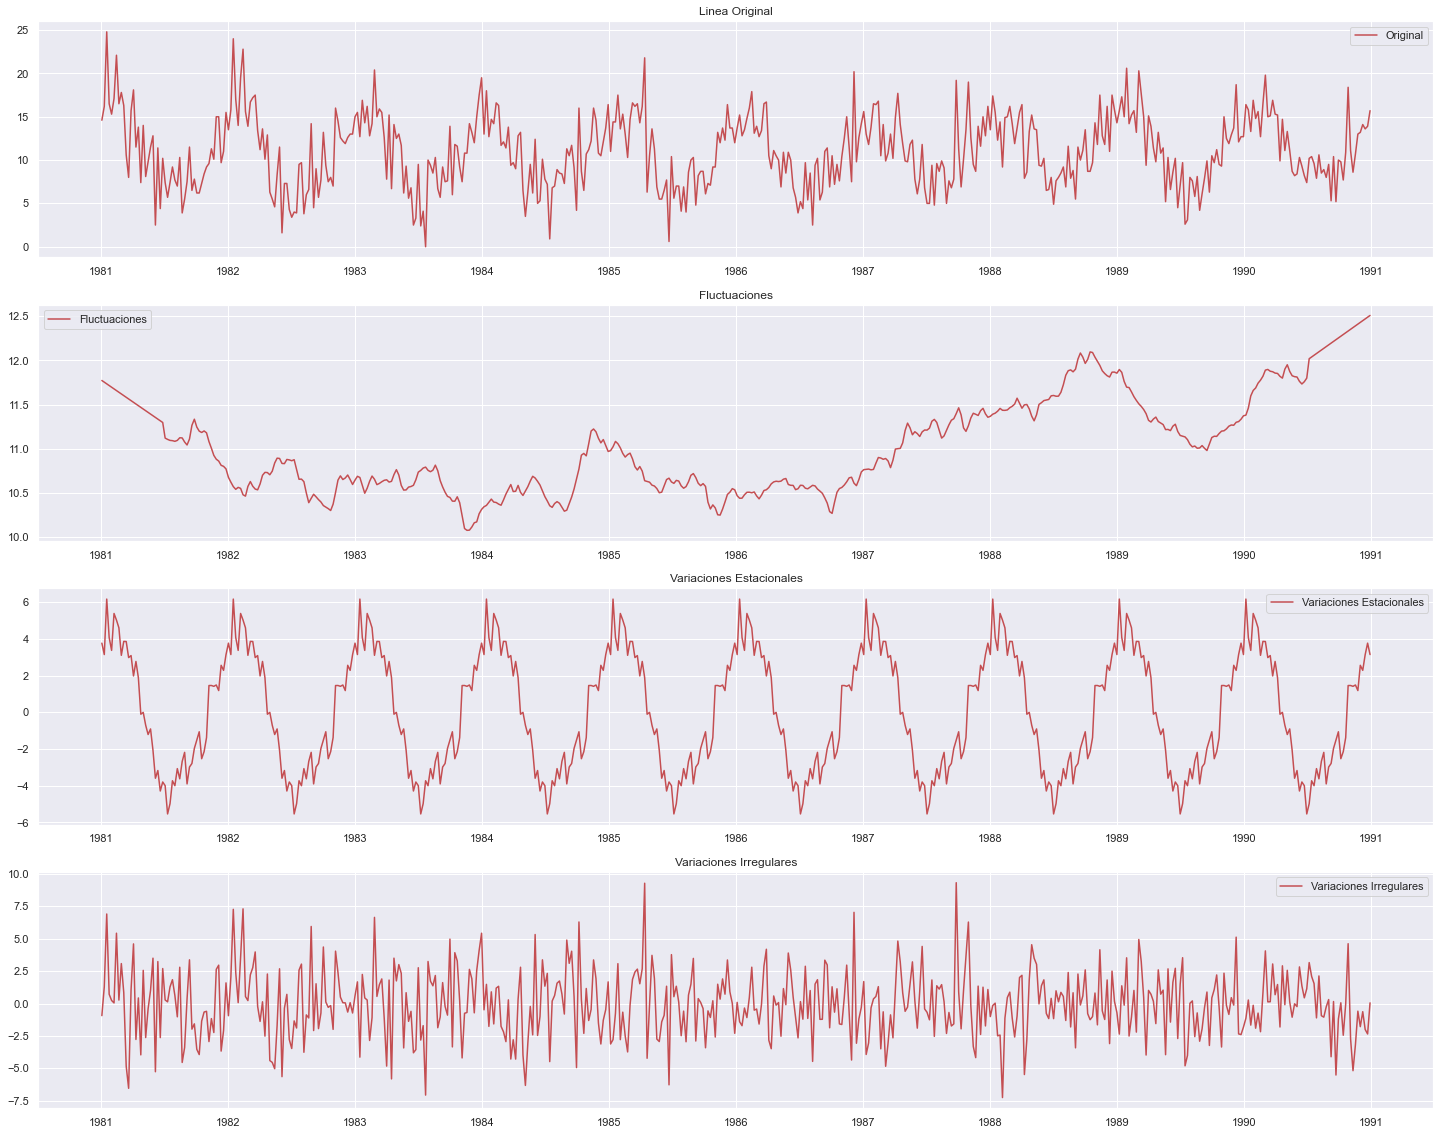

In [10]:
descomposicion = sm.tsa.seasonal_decompose(df['Temp'], extrapolate_trend=30)

tenden = descomposicion.trend
estacio = descomposicion.seasonal
residual = descomposicion.resid

#plt.figure(figsize=(20,5))
sns.set(font_scale=1)
fig, axs = plt.subplots(4,figsize=(25,20))

#plt.subplot(411)
axs[0].plot(df['Temp'], label='Original',c='r')
axs[0].title.set_text('Linea Original')
axs[0].legend(loc='best')

#plt.subplot(412)
axs[1].plot(tenden, label='Fluctuaciones',c='r')
axs[1].title.set_text('Fluctuaciones')
axs[1].legend(loc='best')

#plt.subplot(413)
axs[2].plot(estacio, label='Variaciones Estacionales',c='r')
axs[2].title.set_text('Variaciones Estacionales')
axs[2].legend(loc='best')

#plt.subplot(414)
axs[3].plot(residual, label='Variaciones Irregulares',c='r')
axs[3].title.set_text('Variaciones Irregulares')
axs[3].legend(loc='best')

#                                                                Método Media Móvil
Para poder obtener la tendencia de la serie, aplicamos el método de la media móvil, esta consiste en tomar un rango o ventana de tiempo de los datos
que sea suficientemente y allí promediar la serie de tiempo para obtener la mencionada tendencia.
Tiene como ventaja que nos proporciona una linea suave, que varia poco en respuesta a cambios temporales.

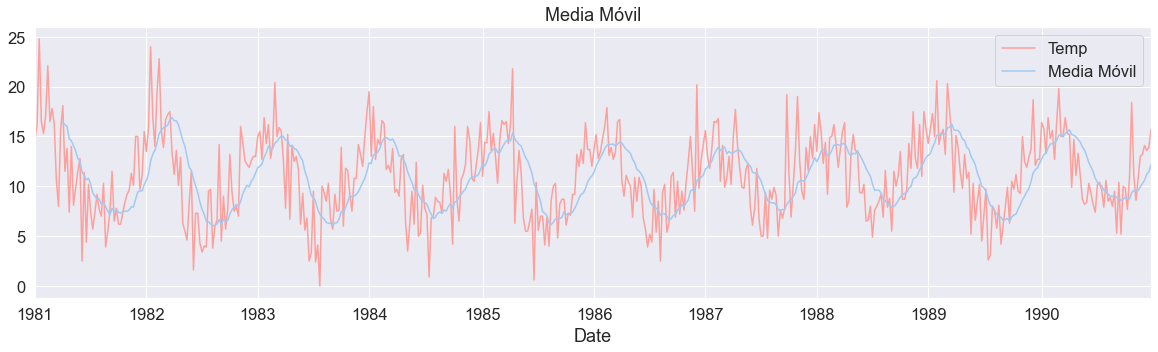

In [11]:
sns.set(font_scale=1.5,palette='pastel')
movi_avg = df['Temp'].rolling(14).mean()
df.Temp.plot(figsize=(20,5), c='r')
movi_avg.plot(figsize=(20,5), label='Media Móvil', c='b')
plt.title('Media Móvil')
plt.legend(loc='best')

In [12]:
from sklearn.metrics import mean_absolute_error

# creamos la mediada de la media para las ventanas de datos, la cual se establese una ventana para los datos de 15 días mediante ensayos

rolling_mean = df['Temp'].rolling(window=15).mean()
# mean_absolute_error(df['Temp'][15:], rolling_mean[15:])

# 
De esta forma, podemos comparar la tendencia de la media calculada en una ventana de 15 días con relación a la serie original.
De igual forma, se definen los límites superior he inferor o intérvalos de confidencia de error.
Al haber tomado una ventana de 15 días, la media móvil se corresponde muy bien con los datos reales y además no se ven valores atípicos
por fuera del intervalo de confianza.

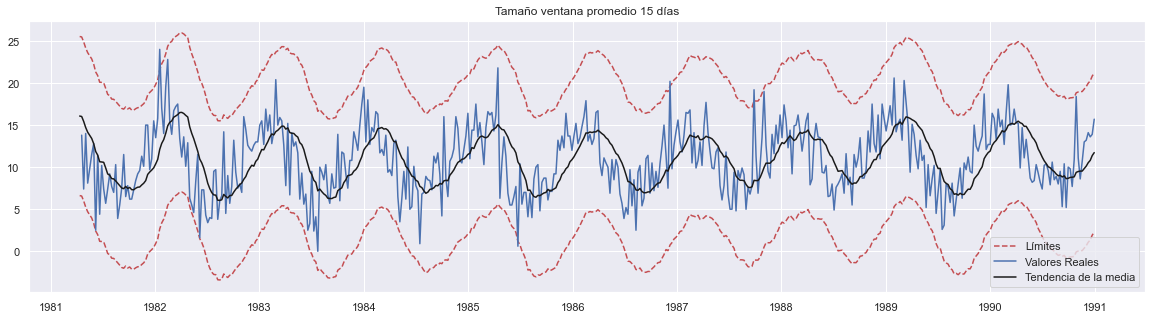

In [13]:
s = df['Temp']
sns.set(font_scale=1)
plt.figure(figsize=(20,5))
rollin_mean = s.rolling(window=15).mean()

if True:
    mae = mean_absolute_error(s[15:], rolling_mean[15:])
    desviacion = np.std(s[15:]-rolling_mean[15:])
    limite_inf = rolling_mean-(mae+1.9*desviacion)
    limite_sup = rollin_mean+(mae+1.9*desviacion)
    plt.plot(limite_sup, 'r--', label='Límites')
    plt.plot(limite_inf, 'r--')

    plt.plot(s[15:], 'b', label='Valores Reales')
    plt.legend(loc='best')
    plt.grid(True)

    plt.title('Tamaño ventana promedio 15 días')
    plt.plot(rolling_mean, 'k', label='Tendencia de la media')
    plt.legend(loc='best')

# Serie Estacionaria

Decimos que una serie de tiempo es estacionaria cuando su media y varianza son constantes en el tiempo, lo cual muestra un comportamiento estable de la serie.
Para determinar si la serie es estacionaria, usamos el método de cálcular el p-valor, este se define como la probabilidad de que un valor estadístico sea posible dada una hipótesis nula. Mientras el p-valor sea más cercano a cero, nos dice que nuestra serie es estacionaria por contradecir una hipótesis nula inicial de considerar que no lo es.


Procedemos a calcular el p-valor mediante una prueba de Dickey-Fuller de estacionalidad.
Para tal motivo añadimos retrasos de 60 días, los cuales se consideran dado que es un proceso autoregresivo que considera dicho periodo.

/home/diego/anaconda3/envs/jupyter-env/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


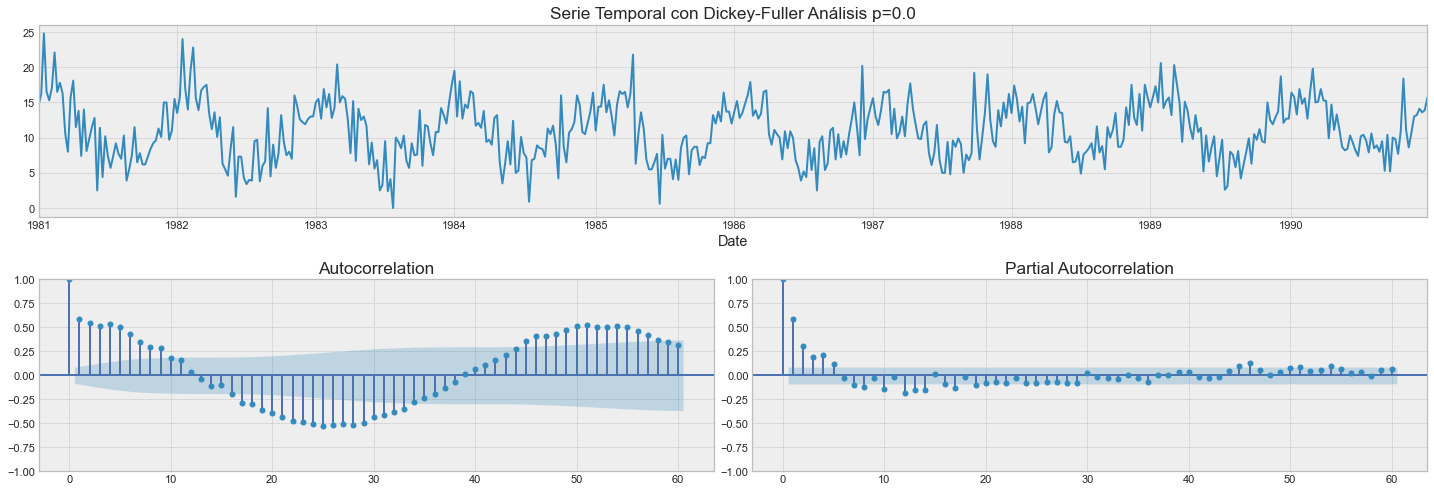

In [14]:
# cálculo de autocorrelación y autocorrelación-parcial
st = df['Temp']
sns.set(font_scale=1)
if not isinstance(st, pd.Series):
    st = pd.Series(st)
with plt.style.context('bmh'):
    fig = plt.figure(figsize=(20,7))
    layout = (2, 2)
    st_ax = plt.subplot2grid(layout, (0,0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1,0))
    pacf_ax = plt.subplot2grid(layout, (1,1))

    st.plot(ax=st_ax)
    p_value = sm.tsa.stattools.adfuller(st)[1] # calculamos el valor p para nuestra serie de tiempo st con retrasos de 60 días
    st_ax.set_title(f'Serie Temporal con Dickey-Fuller Análisis p={p_value.round(2)}')
    smt.graphics.plot_acf(st, lags=60, ax=acf_ax) # gráfica de la función de autocorrelación
    smt.graphics.plot_pacf(st, lags=60, ax=pacf_ax) # ' '    '  '    '  '  ' autocorrelación parcial
    plt.tight_layout()

De igual forma, se ha añadido la autocorrelación de la serie, esta representa el nivel de similitud entre una secuencia de periodos anteriores y los datos reales.
De manera visual, dado que nuestra serie no presenta tendencia, se trata de una serie estacionaria, además su función de autocorrelación muestra una serie de formas 
repetidas en el tiempo.

# Aplicación Método SARIMA
Con el fin de encontrar patrones para encontrar mejores predicciones a futuro, se tienen modelos estadísticos como el ARIMA (modelo autorregresivo integrado de primedio móvil), cuyo caso para series estacionarias en el tiempio se le conoce como método SARIMA.

Para el modelo inicial ARIMA, este se compone por tres partes o modelos:
    -AR Autorregresivo, que se define con el parámetro de orden p
    -I Integrado, el cual nos dice el número de diferencias necesarias para que el modelo sea estacionario y se      define con el parámetro d
    -MA Media Móvil, que se ha comentado y se define según el parámetro q
    
En el caso SARIMA, se añaden 3 parámetros extra debido a la parte estacional que son (P,D,Q) que son los retardos estacionales, nos dice cómo le afectan los ciclos estacionales al modelo actual. 
En general, todos estos son nuestros hiperparámetros.

El concepto de estacional, se define en la serie cuando su media no es constante en el tiempo pero varia de forma periódica.

In [15]:
from itertools import product

# Configuración de los parámetros para el modelo SARIMA

ps = range(0,2)
d = 1
qs = range(0,2)
Ps = range(0,2)
D = 1
Qs = range(0,2)
s = 52

parametros = product(ps, qs, Ps, Qs)
parametros_lista = list(parametros)
len(parametros_lista)

16

In [16]:
def modeloSARIMA(parametros_lista, d, D, s):
    resultado = []
    best_aic = float('inf')

    for param in tqdm_notebook(parametros_lista):
        try:
            model = sm.tsa.statespace.SARIMAX(df['Temp'], order=(param[0], d, param[1]),
                                                seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic

        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        resultado.append([param, model.aic])
    tabla_resultados = pd.DataFrame(resultado)
    tabla_resultados.columns = ['parameters', 'aic']

    tabla_resultados = tabla_resultados.sort_values(by='aic', ascending=True,).reset_index(drop=True)

    return tabla_resultados

In [17]:
%%time
tabla_resultados = modeloSARIMA(parametros_lista, d, D, s)

/home/diego/anaconda3/envs/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/16 [00:00<?, ?it/s]

CPU times: user 13min 38s, sys: 9min 46s, total: 23min 24s
Wall time: 3min 4s


In [18]:
tabla_resultados.head()

,parameters,aic
0,"(0, 1, 0, 1)",2408.895645
1,"(0, 1, 1, 1)",2410.083776
2,"(1, 1, 0, 1)",2410.144669
3,"(1, 1, 1, 1)",2411.430359
4,"(0, 1, 1, 0)",2476.359085


In [19]:
p, q, P, Q = tabla_resultados.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(df['Temp'], order=(p,d,q),
                                        seasonal_order=(P,D,Q,s)).fit(disp=-1)
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               Temp   No. Observations:                  522
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 52)   Log Likelihood               -1201.448
Date:                            Fri, 07 Jan 2022   AIC                           2408.896
Time:                                    02:28:49   BIC                           2421.347
Sample:                                01-04-1981   HQIC                          2413.795
                                     - 12-30-1990                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9810      0.013    -77.842      0.000      -1.006      -0.956
ma.S.L52      -0.8557      0.085   

Todos los coeficientes son significativos y el p-valor es nulo, lo que nos proporciona un buen modelo para nuestro caso.

Por otra parte, podemos calcular de nuevo nuestras gráficas de autocorrelación y parcial autocorrelacionada,
lo que nos muestra que se ha perdido la autocorrelación previa.

/home/diego/anaconda3/envs/jupyter-env/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


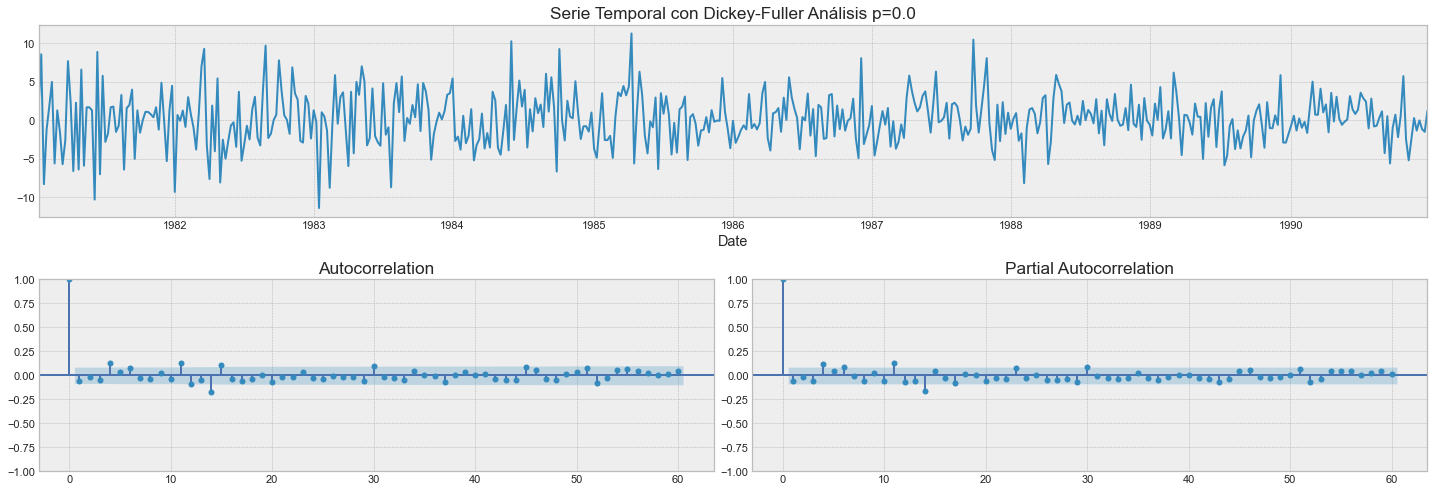

In [20]:
st = best_model.resid[1:]
sns.set(font_scale=1)
if not isinstance(st, pd.Series):
    st = pd.Series(st)
with plt.style.context('bmh'):
    fig = plt.figure(figsize=(20,7))
    layout = (2, 2)
    st_ax = plt.subplot2grid(layout, (0,0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1,0))
    pacf_ax = plt.subplot2grid(layout, (1,1))

    st.plot(ax=st_ax)
    p_value = sm.tsa.stattools.adfuller(st)[1]
    st_ax.set_title(f'Serie Temporal con Dickey-Fuller Análisis p={p_value.round(2)}')
    smt.graphics.plot_acf(st, lags=60, ax=acf_ax)
    smt.graphics.plot_pacf(st, lags=60, ax=pacf_ax)
    plt.tight_layout()

Finalmente, podemos comparar nuestra serie temporal con la predicción mejorada mediante el modelo SARIMA

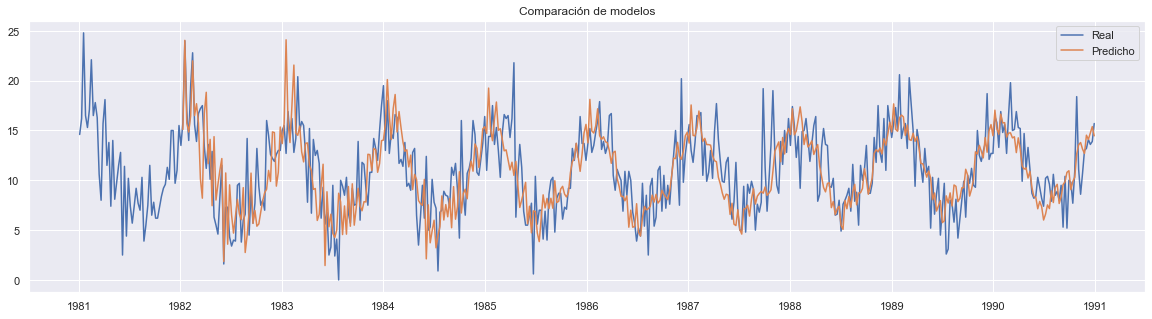

In [22]:
n_steps = 30
dfp = df
dfp['arima_model'] = best_model.fittedvalues
dfp['arima_model'][:s+d] = np.NaN

forecast = best_model.predict(start = dfp.shape[0], end = dfp.shape[0]+n_steps)
forecast = dfp.arima_model.append(forecast)

y_verdadero = dfp['Temp'][s+d:]
y_test = dfp['arima_model'][s+d:]

#error = np.mean(np.abs((y_verdadero - y_test) / y_verdadero))
#print(error)

plt.figure(figsize=(20,5))
plt.title("Comparación de modelos".format(error))

plt.plot(dfp['Temp'], label='Real')
plt.plot(dfp['arima_model'],label='Predicho')
plt.legend(loc='best')
plt.grid(True)

Se observa un comportamiento semejante entre el modelo y los valores reales.